to cover in this notebook:
 - very short explanation of what raster data is
 - getting a demo sentinel-2 image using STAC
 - what are bands
 - making a true colour image
 - calculating indices

# working with satellite data
For this demo we will use data from the Sentinel-2 satellite. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery over the majority of the Earth's terrestrial surface. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

We will use pystac (a python STAC package) to find an image that was captured within a specific date range, at the location we want, and has less that XX cloud cover.

In [40]:
import pandas
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pystac_client


## Finding an image via STAC

PySTAC-Client (pystac-client) is an extension of the PySTAC library. It adds support for STAC APIs and static STAC catalogs. You can use PySTAC-Client with both static catalogs and dynamic catalogs that use APIs. Its main purpose is to support STAC API endpoints like search. 
You can interact with the [Sentinel-2 Level 2A catalog here](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a)

In [41]:
# TODO: add jupyter widget to let user upload geojson of their AOI

In [42]:
# Initialize the STAC client
url = "https://earth-search.aws.element84.com/v1"
client = pystac_client.Client.open(url)

# Define the search parameters
bbox = [145.8, -37.3, 146.0, -37.1]  # near Lake Eildon, Victoria
time_range = "2023-01-01/2023-01-30"

search = client.search(
    max_items=1,
    collections=['sentinel-2-l2a'],
    datetime=time_range,
    bbox=bbox,
    #query={"eo:cloud_cover": {"lt": 20}}
)
print(f"{search.matched()} items found")
    
# Remember, only 1 item will be printed because we've set a max items limit
for item in search.items():
    print(item.id)


40 items found
S2A_55HCU_20230130_0_L2A


Each item has a series of assets associated with it. Some of these assets are the COGs for the spectral bands we are interested in.

note, the asstes ending in `-jp2` are JPEG2000 files, an alternative to the COGs. Unless you have a good reason to do so, you should use the COG version. e.g. use `blue` not `blue-jp2`.

In [43]:
assets = item.assets
for k in assets.keys():
    print(k)

aot
blue
coastal
granule_metadata
green
nir
nir08
nir09
red
rededge1
rededge2
rededge3
scl
swir16
swir22
thumbnail
tileinfo_metadata
visual
wvp
aot-jp2
blue-jp2
coastal-jp2
green-jp2
nir-jp2
nir08-jp2
nir09-jp2
red-jp2
rededge1-jp2
rededge2-jp2
rededge3-jp2
scl-jp2
swir16-jp2
swir22-jp2
visual-jp2
wvp-jp2


Use item_collection() to convert all Items from a search into a single PySTAC ItemCollection. The ItemCollection can then be saved as a GeoJSON FeatureCollection.

In [44]:
item_collection = search.item_collection()
item_collection.save_object('data/temp/demo_stac_itemcollection.json')

## Visualise the data
(we set a max items limit in the stac search, so we will only have 1 image to work with here. But, you can run these processes iteratively over an entire collection.)
## getting data from the STAC items
now that we have the id for the satellite image, we will fetch the actual data. In this case, we are going to fetch the COGs (cloud-optimised geotiffs) for the blue, green, red and near-infrared spectral bands. Each band is stored as a separate, single-band COG:

In [45]:
bands = ['blue','green','red','nir']
band_urls = {band: item.assets[band].href for band in bands}
band_urls

{'blue': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/CU/2023/1/S2A_55HCU_20230130_0_L2A/B02.tif',
 'green': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/CU/2023/1/S2A_55HCU_20230130_0_L2A/B03.tif',
 'red': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/CU/2023/1/S2A_55HCU_20230130_0_L2A/B04.tif',
 'nir': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/CU/2023/1/S2A_55HCU_20230130_0_L2A/B08.tif'}

### Checking bands

added a window to save on processing entire sentinel-2 image:

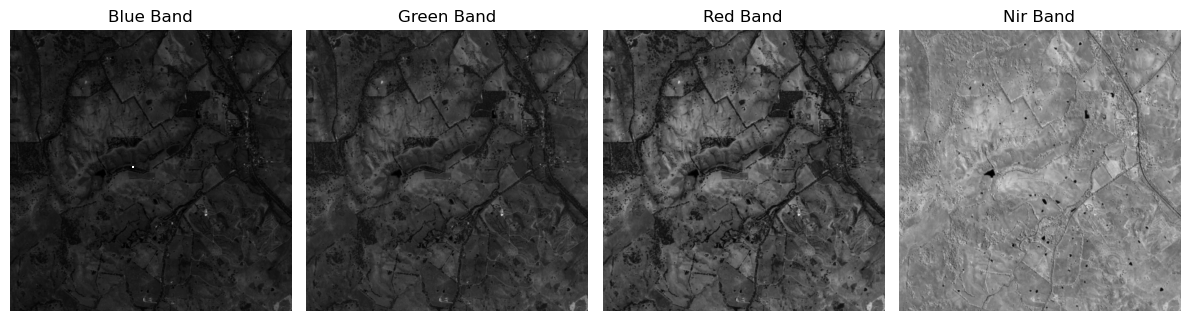

In [46]:
# Initialize a figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Read and display each band in a subplot
for i, band in enumerate(bands):
    with rasterio.open(item.assets[band].href) as band_data:
        # Read a window of data from the band
        data = band_data.read(1,window=Window(0,0,500,500),masked=True)
        # Display the data in the corresponding subplot
        axes[i].imshow(data, cmap='gray')
        axes[i].set_title(f"{band.capitalize()} Band")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### True colour image

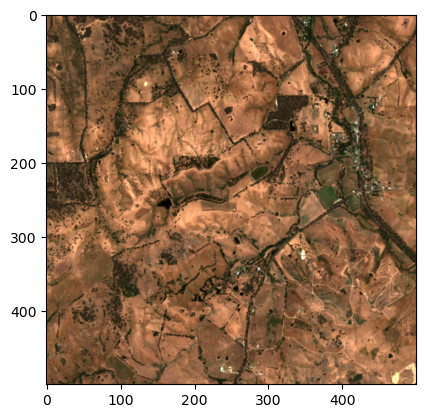

<Axes: >

In [47]:
vis_band_data = item.assets['visual'].href

with rasterio.open(vis_band_data) as src:
    data = src.read(window=Window(0,0,500,500), masked=True)

show(data)

### Calculating spectral indices